# Housing price prediction

## Deep learning project with LSTM and GRU

### Import necessary libraries and data

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError 
from keras.layers import InputLayer
from keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

# Set TensorFlow log level to WARNING to suppress less critical messages
tf.get_logger().setLevel('WARNING')

# Ignore warnings from other libraries (e.g., NumPy)
warnings.filterwarnings("ignore")

# Set an environment variable to suppress low-level TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Data is collected from kaggle: https://www.kaggle.com/datasets/anthonypino/melbourne-housing-market?datasetId=423&searchQuery=feature+selection

In [2]:
# Import data from a CSV file named "melb.csv" into a DataFrame called 'data'
data = pd.read_csv("melb.csv")

# Drop rows with missing values (NaN) in the DataFrame 'data'
data.dropna(inplace=True)

# Reset the index of the DataFrame after dropping rows to avoid gaps in the index
data.reset_index(drop=True, inplace=True)

# Create a new DataFrame 'date' and copy the 'Date' column from the original 'data' DataFrame into it
date = pd.DataFrame()
date['Date'] = data['Date']

# Define a list of column names to drop from the 'data' DataFrame
dropcols = ['Suburb', 'Date', 'Address', 'Method', 'SellerG', 'Postcode', 'Bedroom2', 'CouncilArea', 'Regionname']

# Drop the specified columns from the 'data' DataFrame
data = data.drop(dropcols, axis=1)

# Create a new DataFrame 'df' by joining the 'date' DataFrame with the modified 'data' DataFrame
df = date.join(data)

# Convert the 'Date' column in 'df' to a datetime format with a specified date format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Display the first few rows of the final DataFrame 'df'
df.head()

,Date,Rooms,Type,Price,Distance,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
0,2016-02-04,2,h,1035000.0,2.5,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,4019.0
1,2017-03-04,3,h,1465000.0,2.5,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,4019.0
2,2016-06-04,4,h,1600000.0,2.5,1.0,2.0,120.0,142.0,2014.0,-37.8072,144.9941,4019.0
3,2016-05-07,3,h,1876000.0,2.5,2.0,0.0,245.0,210.0,1910.0,-37.8024,144.9993,4019.0
4,2016-10-08,2,h,1636000.0,2.5,1.0,2.0,256.0,107.0,1890.0,-37.8060,144.9954,4019.0


### Data preprocessing

One-hot encoding is applied to the 'Type' column 'df' to convert it into binary columns. Three binary columns, 'Type_h', 'Type_t', and 'Type_u', are created to represent the different categories within the 'Type' column. Then, a LabelEncoder is used to further convert these binary columns into numerical values. Finally, the first few rows of the updated 'df' are displayed.

In [3]:
# Use one-hot encoding to convert the 'Type' column into binary columns
df = pd.get_dummies(df, columns=['Type'], prefix='Type')

# Initialize a LabelEncoder to convert the 'Type_h', 'Type_t', and 'Type_u' columns to numerical values
label_encoder = LabelEncoder()

# Encode the 'Type_h' column
df['Type_h'] = label_encoder.fit_transform(df['Type_h'])

# Encode the 'Type_t' column
df['Type_t'] = label_encoder.fit_transform(df['Type_t'])

# Encode the 'Type_u' column
df['Type_u'] = label_encoder.fit_transform(df['Type_u'])

# Display the first few rows of the updated DataFrame 'df'
df.head()

,Date,Rooms,Price,Distance,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,Type_h,Type_t,Type_u
0,2016-02-04,2,1035000.0,2.5,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,4019.0,1,0,0
1,2017-03-04,3,1465000.0,2.5,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,4019.0,1,0,0
2,2016-06-04,4,1600000.0,2.5,1.0,2.0,120.0,142.0,2014.0,-37.8072,144.9941,4019.0,1,0,0
3,2016-05-07,3,1876000.0,2.5,2.0,0.0,245.0,210.0,1910.0,-37.8024,144.9993,4019.0,1,0,0
4,2016-10-08,2,1636000.0,2.5,1.0,2.0,256.0,107.0,1890.0,-37.8060,144.9954,4019.0,1,0,0


Feature scaling is performed on numerical columns in 'df'. The standardisation process transforms the data so that they have a mean on 0 and a standard deviation of 1.

In [4]:
# Define the columns you want to scale (numerical features)
numerical_features = ['Rooms', 'Price', 'Distance', 'Bathroom', 'Car', 'Landsize', 
                      'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the data and transform the selected numerical columns
df[numerical_features] = scaler.fit_transform(df[numerical_features])
df.head()

,Date,Rooms,Price,Distance,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,Type_h,Type_t,Type_u
0,2016-02-04,-1.140264,-0.085232,-1.27695,-0.895892,-1.734910,-0.346267,-0.799693,-1.775256,-0.037540,0.016874,-0.790198,1,0,0
1,2017-03-04,-0.102631,0.547732,-1.27695,0.489973,-1.734910,-0.366997,0.007854,-1.775256,-0.053003,0.025283,-0.790198,1,0,0
2,2016-06-04,0.935002,0.746453,-1.27695,-0.895892,0.315512,-0.380188,-0.083137,1.302598,-0.029809,0.022761,-0.790198,1,0,0
3,2016-05-07,-0.102631,1.152728,-1.27695,0.489973,-1.734910,-0.262404,0.690288,-1.505269,0.023204,0.066490,-0.790198,1,0,0
4,2016-10-08,-1.140264,0.799446,-1.27695,-0.895892,0.315512,-0.252039,-0.481224,-2.045243,-0.016556,0.033693,-0.790198,1,0,0


### Data visualisation and further preprocessing

#### Line plot which displays Price over time

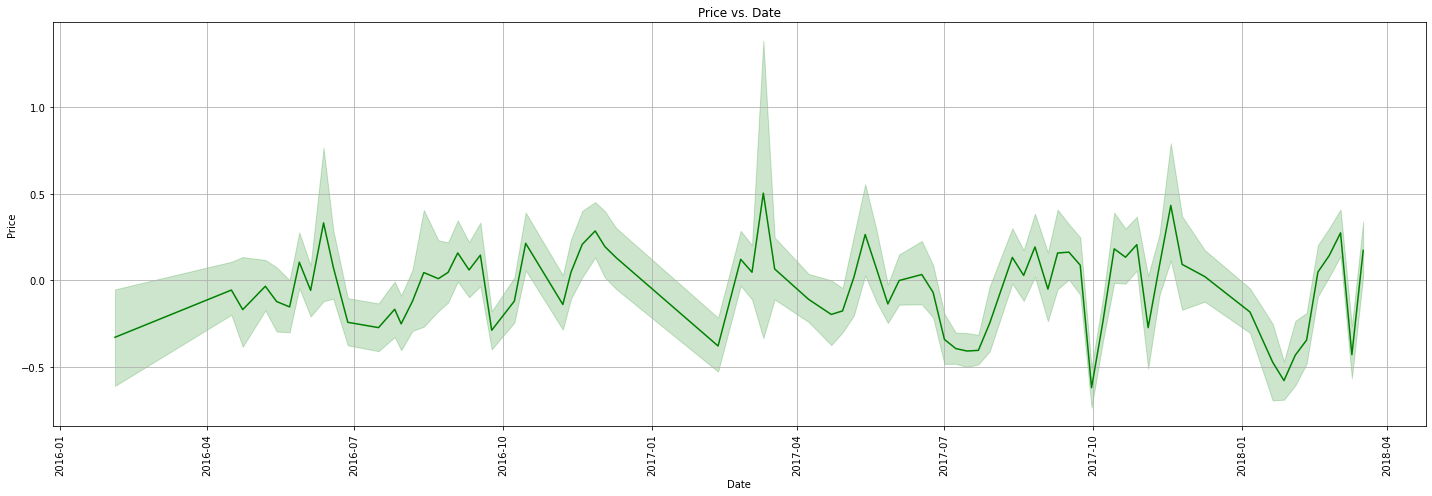

In [5]:
# Creating a line plot that visually represents the relationship between 'Date' and 'Price' 
# in 'df'.

# Create the plot with a specific figure size
plt.figure(figsize=(20, 7))

# Create a line plot with 'Date' on the x-axis and 'Price' on the y-axis using data from the 'df' DataFrame
sns.lineplot(x='Date', y='Price', data=df, color='green')

# Customize the plot by setting the title, x-label, y-label, and enabling grid lines
plt.title('Price vs. Date')       
plt.xlabel('Date')                
plt.ylabel('Price')               
plt.grid(True)                    

# Show the plot
# Set x-axis ticks to improve readability, and rotate the labels for better presentation
x_ticks = df['Date'].iloc[::5]   
plt.xticks(rotation=90)    
plt.tight_layout()    
plt.show()

#### Distribution plot

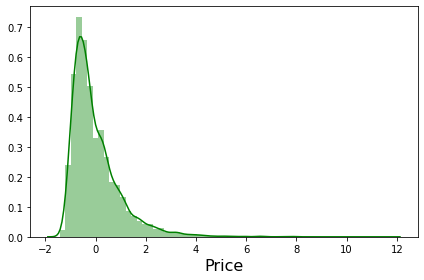

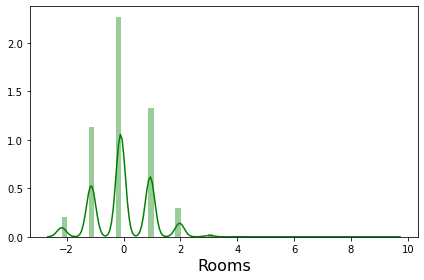

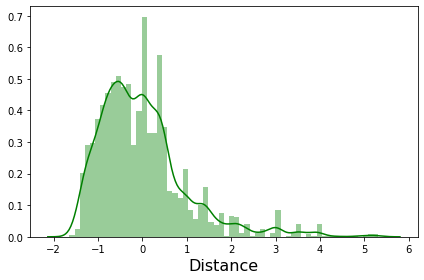

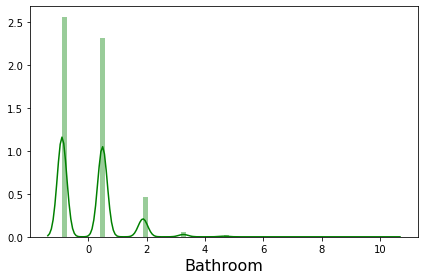

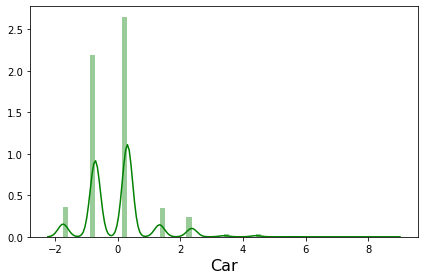

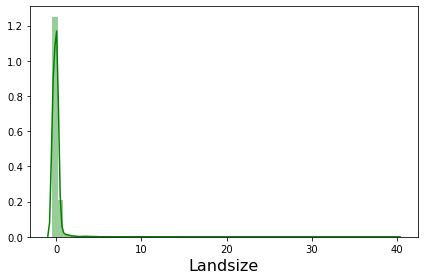

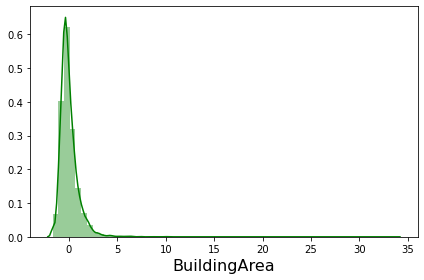

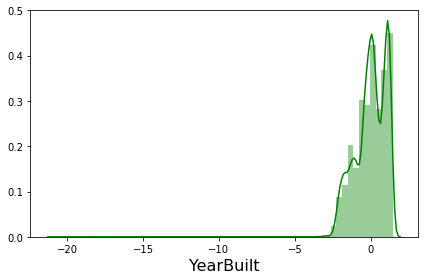

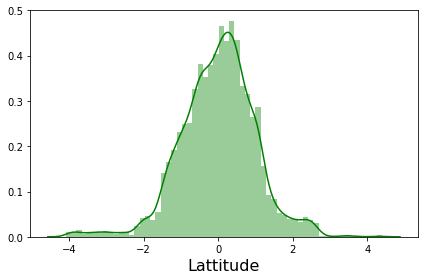

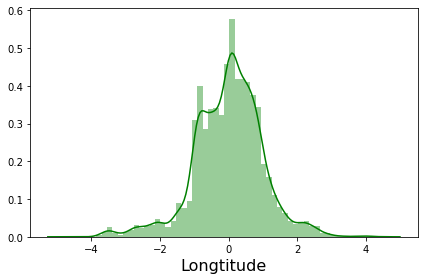

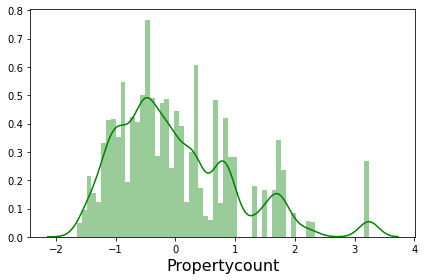

In [6]:
# A series of distribution plots, each representing the distribution of values for a selected 
# column of 'df' is generated

# Define a list of selected columns for which distribution plots will be created
selected_columns = ['Price', 'Rooms', 'Distance', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']

# Loop through each selected column and create a distribution plot
for i in selected_columns:
    # Create a distribution plot (histogram) for the current column in the 'df' DataFrame
    sns.distplot(df[i], bins=60, color='green')  # Specify the number of bins and color
    
    # Set the x-axis label with the current column name and adjust the font size
    plt.xlabel(i, fontsize=16)
    
    # Remove the y-axis label to save space
    plt.ylabel('')
    
    # Ensure tight layout for better plot appearance
    plt.tight_layout()
    
    # Display the distribution plot for the current column
    plt.show()

In [7]:
# Define a function to remove outliers based on the Interquartile Range (IQR)
def remove_outliers_iqr(data_frame, column):
    Q1 = data_frame[column].quantile(0.25)  # Calculate the first quartile (Q1)
    Q3 = data_frame[column].quantile(0.75)  # Calculate the third quartile (Q3)
    IQR = Q3 - Q1  # Calculate the Interquartile Range (IQR)
    lower_bound = Q1 - 1.5 * IQR  # Calculate the lower bound for outliers
    upper_bound = Q3 + 1.5 * IQR  # Calculate the upper bound for outliers
    # Filter the DataFrame to keep only data points within the bounds
    return data_frame[(data_frame[column] >= lower_bound) & (data_frame[column] <= upper_bound)]

# Specify the columns for which you want to remove outliers
columns_to_clean = ['Price', 'Rooms', 'Distance', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']

# Loop through the specified columns and remove outliers using the defined function
for column in columns_to_clean:
    df = remove_outliers_iqr(df, column)

# The DataFrame 'df' now contains the data with outliers removed

#### Distribution plot after removing outliers

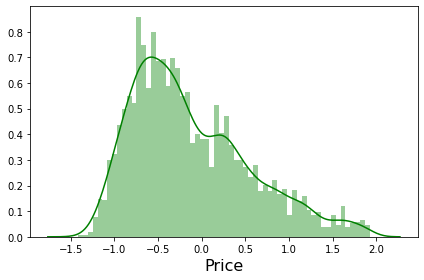

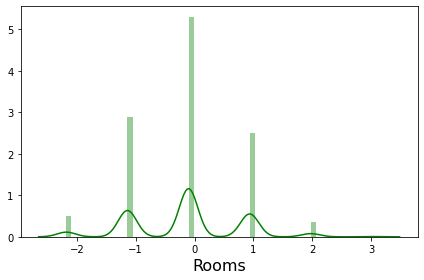

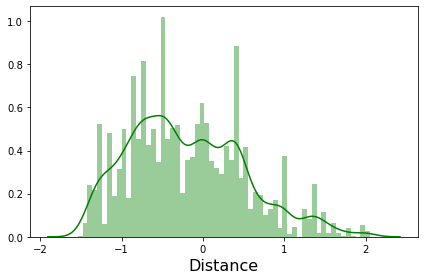

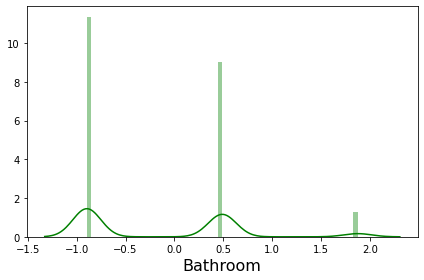

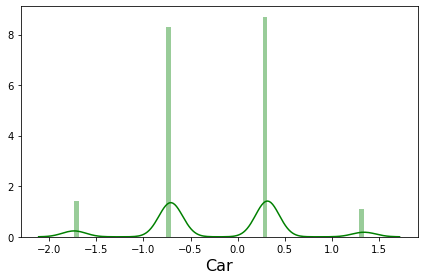

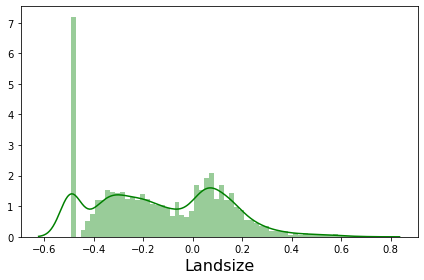

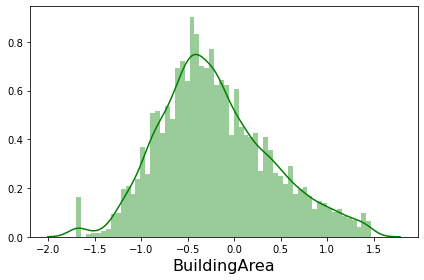

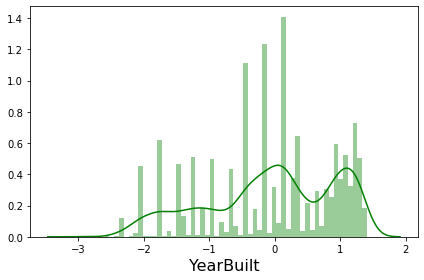

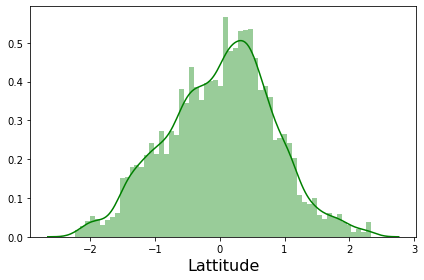

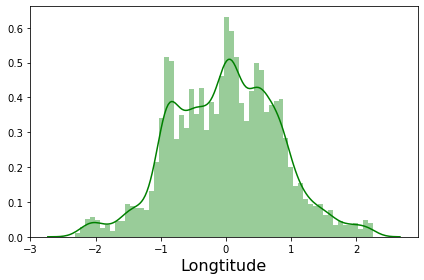

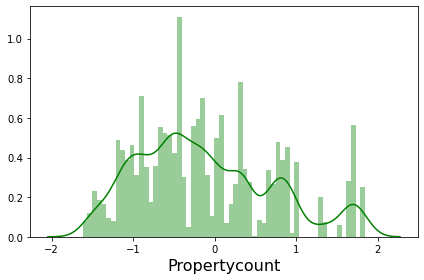

In [8]:
# Define a list of selected columns for which distribution plots will be created
selected_columns = ['Price', 'Rooms', 'Distance', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']

# Loop through each selected column to create distribution plots
for i in selected_columns:
    # Create a distribution plot (histogram) for the current column in the 'df' DataFrame
    sns.distplot(df[i], bins=60, color='green')  # Specify the number of bins and color
    
    # Set the x-axis label with the current column name and adjust the font size
    plt.xlabel(i, fontsize=16)
    
    # Remove the y-axis label to save space
    plt.ylabel('')
    
    # Ensure tight layout for better plot appearance
    plt.tight_layout()
    
    # Display the distribution plot for the current column
    plt.show()

#### Correlation matrix

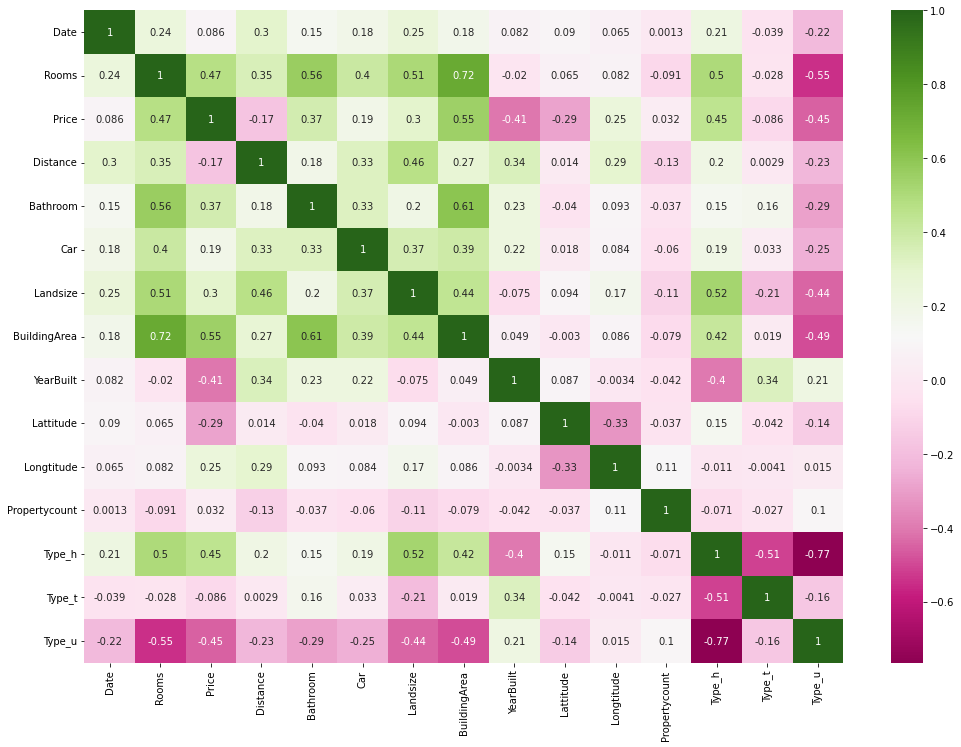

In [9]:
# Create a heatmap plot with a specified figure size
plt.figure(figsize=(17, 12))

# Generate a heatmap of the correlation matrix of the DataFrame 'df'
sns.heatmap(df.corr(), annot=True, cmap="PiYG")

# Display the heatmap with annotations (correlation values) and using the 'PiYG' color map
plt.show()

#### Top correlated features with 'Price'

In [10]:
# Get the column names
cols = df.columns

# Calculate the correlation matrix
corr = df.corr()

# Print the top 6 correlated features with 'Price'
top_corr_features = corr['Price'].sort_values(ascending=False)[1:]

# Display the correlated features with 'Price' in descending order
print("Correlated features with Price:")
print(top_corr_features)

Correlated features with Price:
BuildingArea     0.546203
Rooms            0.474793
Type_h           0.447208
Bathroom         0.368572
Landsize         0.303016
Longtitude       0.246038
Car              0.185044
Date             0.085613
Propertycount    0.032433
Type_t          -0.086361
Distance        -0.172391
Lattitude       -0.288275
YearBuilt       -0.409841
Type_u          -0.448603
Name: Price, dtype: float64


### Baseline - Linear Regression

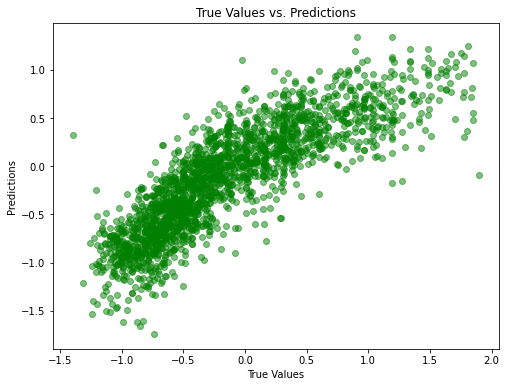

In [11]:
# Split the data into features (X) and the target variable (y)
X = df.drop(['Price', 'Date'], axis=1)  # Features (independent variables)
y = df['Price']  # Target variable (dependent variable)

# Split the data into training and testing sets (70% train, 30% test)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3, random_state=0)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(Xtrain, Ytrain)

# Make predictions on the test data
Ypred = model.predict(Xtest)

# Calculate the Mean Squared Error (MSE) between the true values (Ytest) and predictions(Ypred)
mseBase = mean_squared_error(Ytest, Ypred)

# Create a scatter plot to visualize the relationship between true values and predictions
plt.figure(figsize=(8, 6))
plt.scatter(Ytest, Ypred, alpha=0.5, color='green')  # Scatter plot with green color
plt.xlabel("True Values")  # X-axis label
plt.ylabel("Predictions")  # Y-axis label
plt.title("True Values vs. Predictions")  # Plot title
plt.show()  # Display the plot

### LSTM

In [12]:
def df_to_X_y(df, window_size=5):
    # Convert the DataFrame 'df' to a NumPy array 'df_as_np'
    df_as_np = df.to_numpy()
    
    # Initialize empty lists to store input features (X) and labels (y)
    X = []
    y = []
    
    # Iterate through the data, creating sequences of 'window_size' data points
    for i in range(len(df_as_np) - window_size):
        # Extract a sequence of 'window_size' data points and format them as sublists
        row = [[a] for a in df_as_np[i:i + 5]]
        
        # Append the sequence to the input features (X)
        X.append(row)
        
        # Extract the label (next data point after the sequence) and append it to labels (y)
        label = df_as_np[i + 5]
        y.append(label)
    
    # Convert the lists to NumPy arrays and return them as input features (X) and labels (y)
    return np.array(X), np.array(y)

# Extract the 'Price' column from the DataFrame 'df' and assign it to the variable 'price'
price = df['Price']

# Define the window size for creating sequences (in this case, a window size of 5)
WINDOW_SIZE = 5

# Call the 'df_to_X_y' function to create input features (X) and labels (y) using the 'price' column and the specified window size
X, y = df_to_X_y(price, WINDOW_SIZE)

# Print the shapes of the resulting arrays to check their dimensions
X.shape, y.shape

((6752, 5, 1), (6752,))

In [13]:
# Split the dataset into training, validation, and test sets

# Select the first 6000 samples for training data and labels
X_train, y_train = X[:6000], y[:6000]

# Select samples from 6000 to 6500 for validation data and labels
X_val, y_val = X[6000:6500], y[6000:6500]

# Select samples from 6500 onwards for test data and labels
X_test, y_test = X[6500:], y[6500:]

# Print the shapes of the resulting arrays to check their dimensions
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((6000, 5, 1), (6000,), (500, 5, 1), (500,), (252, 5, 1), (252,))

In [14]:
# Define the architecture of the neural network model
model1 = Sequential()

# Add an input layer with the specified input shape of (5, 1)
model1.add(InputLayer(input_shape=(5, 1)))

# Add an LSTM layer with 64 units
model1.add(LSTM(64))

# Add a Dense layer with 8 units and ReLU activation function
model1.add(Dense(8, activation='relu'))

# Add a final Dense layer with 1 unit and linear activation for regression
model1.add(Dense(1, activation='linear'))

# Display a summary of the model's architecture
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError

# Create a ModelCheckpoint callback to save the best model during training
cp = ModelCheckpoint('model1/', save_best_only=True)

# Compile the LSTM model with Mean Squared Error (MSE) as the loss function, Adam optimizer with a learning rate of 0.0001,
# and Root Mean Squared Error (RMSE) as a metric for evaluation
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Train the LSTM model on the training data (X_train, y_train) with validation on the validation data (X_val, y_val)
# The training is performed for 50 epochs, and the ModelCheckpoint callback is used to save the best model during training
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp])

# Evaluate the LSTM model on the test data (X_test, y_test) to calculate the loss (MSE) on unseen data
loss_lstm = model1.evaluate(X_test, y_test)
print(f'--- \n Test Loss: {loss_lstm[0]}')

# Make predictions using the trained LSTM model on the test data
predictions1 = model1.predict(X_test)

Epoch 1/50
186/188 [============================>.] - ETA: 0s - loss: 0.4294 - root_mean_squared_error: 0.6553

188/188 [==============================] - 4s 17ms/step - loss: 0.4299 - root_mean_squared_error: 0.6557 - val_loss: 0.4717 - val_root_mean_squared_error: 0.6868
Epoch 2/50
177/188 [===========================>..] - ETA: 0s - loss: 0.4197 - root_mean_squared_error: 0.6478

188/188 [==============================] - 2s 13ms/step - loss: 0.4204 - root_mean_squared_error: 0.6484 - val_loss: 0.4685 - val_root_mean_squared_error: 0.6844
Epoch 3/50
177/188 [===========================>..] - ETA: 0s - loss: 0.4158 - root_mean_squared_error: 0.6449

188/188 [==============================] - 3s 13ms/step - loss: 0.4192 - root_mean_squared_error: 0.6474 - val_loss: 0.4655 - val_root_mean_squared_error: 0.6823
Epoch 4/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4184 - root_mean_squared_error: 0.6469 - val_loss: 0.4667 - val_root_mean_squared_error: 0.6832
Epoch 5/50
171/188 [==========================>...] - ETA: 0s - loss: 0.4181 - root_mean_squared_error: 0.6466

188/188 [==============================] - 3s 15ms/step - loss: 0.4179 - root_mean_squared_error: 0.6464 - val_loss: 0.4641 - val_root_mean_squared_error: 0.6812
Epoch 6/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4175 - root_mean_squared_error: 0.6461 - val_loss: 0.4648 - val_root_mean_squared_error: 0.6818
Epoch 7/50
178/188 [===========================>..] - ETA: 0s - loss: 0.4159 - root_mean_squared_error: 0.6449

188/188 [==============================] - 2s 13ms/step - loss: 0.4171 - root_mean_squared_error: 0.6458 - val_loss: 0.4635 - val_root_mean_squared_error: 0.6808
Epoch 8/50
179/188 [===========================>..] - ETA: 0s - loss: 0.4167 - root_mean_squared_error: 0.6455

188/188 [==============================] - 3s 14ms/step - loss: 0.4168 - root_mean_squared_error: 0.6456 - val_loss: 0.4627 - val_root_mean_squared_error: 0.6802
Epoch 9/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4166 - root_mean_squared_error: 0.6455 - val_loss: 0.4632 - val_root_mean_squared_error: 0.6806
Epoch 10/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4166 - root_mean_squared_error: 0.6455 - val_loss: 0.4631 - val_root_mean_squared_error: 0.6805
Epoch 11/50
176/188 [===========================>..] - ETA: 0s - loss: 0.4168 - root_mean_squared_error: 0.6456

188/188 [==============================] - 3s 14ms/step - loss: 0.4163 - root_mean_squared_error: 0.6452 - val_loss: 0.4605 - val_root_mean_squared_error: 0.6786
Epoch 12/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4164 - root_mean_squared_error: 0.6453 - val_loss: 0.4621 - val_root_mean_squared_error: 0.6798
Epoch 13/50
178/188 [===========================>..] - ETA: 0s - loss: 0.4202 - root_mean_squared_error: 0.6482

188/188 [==============================] - 2s 13ms/step - loss: 0.4163 - root_mean_squared_error: 0.6452 - val_loss: 0.4603 - val_root_mean_squared_error: 0.6784
Epoch 14/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4162 - root_mean_squared_error: 0.6452 - val_loss: 0.4618 - val_root_mean_squared_error: 0.6796
Epoch 15/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4162 - root_mean_squared_error: 0.6451 - val_loss: 0.4617 - val_root_mean_squared_error: 0.6795
Epoch 16/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4161 - root_mean_squared_error: 0.6451 - val_loss: 0.4616 - val_root_mean_squared_error: 0.6794
Epoch 17/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4160 - root_mean_squared_error: 0.6450 - val_loss: 0.4609 - val_root_mean_squared_error: 0.6789
Epoch 18/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4161 - root_mean_squared_error: 0.6450 - val_loss: 0.4610 - val_root_

188/188 [==============================] - 3s 14ms/step - loss: 0.4160 - root_mean_squared_error: 0.6450 - val_loss: 0.4596 - val_root_mean_squared_error: 0.6779
Epoch 21/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4160 - root_mean_squared_error: 0.6450 - val_loss: 0.4609 - val_root_mean_squared_error: 0.6789
Epoch 22/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4159 - root_mean_squared_error: 0.6449 - val_loss: 0.4599 - val_root_mean_squared_error: 0.6781
Epoch 23/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4159 - root_mean_squared_error: 0.6449 - val_loss: 0.4607 - val_root_mean_squared_error: 0.6788
Epoch 24/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4160 - root_mean_squared_error: 0.6450 - val_loss: 0.4602 - val_root_mean_squared_error: 0.6784
Epoch 25/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4158 - root_mean_squared_error: 0.6448 - val_loss: 0.4624 - val_root_

188/188 [==============================] - 2s 13ms/step - loss: 0.4158 - root_mean_squared_error: 0.6448 - val_loss: 0.4594 - val_root_mean_squared_error: 0.6778
Epoch 34/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4158 - root_mean_squared_error: 0.6448 - val_loss: 0.4597 - val_root_mean_squared_error: 0.6780
Epoch 35/50
184/188 [============================>.] - ETA: 0s - loss: 0.4151 - root_mean_squared_error: 0.6443

188/188 [==============================] - 3s 15ms/step - loss: 0.4157 - root_mean_squared_error: 0.6447 - val_loss: 0.4591 - val_root_mean_squared_error: 0.6776
Epoch 36/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4157 - root_mean_squared_error: 0.6448 - val_loss: 0.4610 - val_root_mean_squared_error: 0.6790
Epoch 37/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4158 - root_mean_squared_error: 0.6448 - val_loss: 0.4608 - val_root_mean_squared_error: 0.6788
Epoch 38/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4155 - root_mean_squared_error: 0.6446 - val_loss: 0.4630 - val_root_mean_squared_error: 0.6804
Epoch 39/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4158 - root_mean_squared_error: 0.6448 - val_loss: 0.4601 - val_root_mean_squared_error: 0.6783
Epoch 40/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4157 - root_mean_squared_error: 0.6448 - val_loss: 0.4616 - val_root_

188/188 [==============================] - 2s 13ms/step - loss: 0.4156 - root_mean_squared_error: 0.6447 - val_loss: 0.4586 - val_root_mean_squared_error: 0.6772
Epoch 47/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4156 - root_mean_squared_error: 0.6447 - val_loss: 0.4595 - val_root_mean_squared_error: 0.6779
Epoch 48/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4156 - root_mean_squared_error: 0.6446 - val_loss: 0.4608 - val_root_mean_squared_error: 0.6788
Epoch 49/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4156 - root_mean_squared_error: 0.6446 - val_loss: 0.4590 - val_root_mean_squared_error: 0.6775
Epoch 50/50
8/8 [==============================] - 0s 1ms/step - loss: 0.4185 - root_mean_squared_error: 0.6469
--- 
 Test Loss: 0.4184877872467041
8/8 [==============================] - 0s 1ms/step


#### Visual display

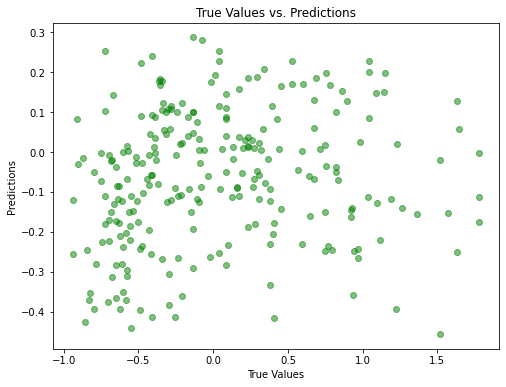

In [16]:
# Create a scatter plot to visualize the relationship between true values (y_test) and predictions (predictions1)
plt.figure(figsize=(8, 6))

# Scatter plot with transparency (alpha) to better visualize overlapping points
plt.scatter(y_test, predictions1, alpha=0.5, color='green')

# Label the x-axis as "True Values"
plt.xlabel("True Values")

# Label the y-axis as "Predictions"
plt.ylabel("Predictions")

# Set the title of the plot
plt.title("True Values vs. Predictions")

# Display the scatter plot
plt.show()

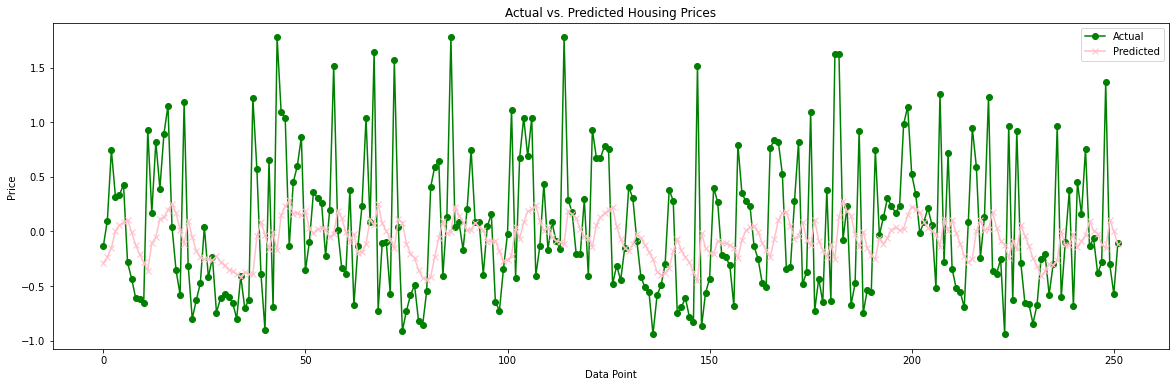

In [17]:
plt.figure(figsize=(20, 6))  # Set the figure size

plt.plot(y_test, label='Actual', color='green', marker='o')  # Plot the actual values in green with 'o' markers
plt.plot(predictions1, label='Predicted', color='pink', marker='x')  # Plot the predicted values in pink with 'x' markers

plt.xlabel('Data Point')  # Set the x-axis label
plt.ylabel('Price')  # Set the y-axis label
plt.legend()  # Add a legend to distinguish between 'Actual' and 'Predicted'

plt.title('Actual vs. Predicted Housing Prices')  # Set the title for the plot

plt.show()  # Display the plot

### GRU_1

In [18]:
# Load the data and define features and target variable
features = ['Rooms', 'Distance', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
            'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount', 'Type_h', 'Type_t', 'Type_u']
target = ['Price']
X = df[features].values
y = df[target].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a Sequential model using Keras
model2 = Sequential()

# Add a GRU (Gated Recurrent Unit) layer with 64 units, specifying input shape and activation function
model2.add(GRU(units=64, input_shape=(X_train.shape[1], 1), activation='relu', return_sequences=False))
model2.add(Dropout(0.2))  # Add dropout for regularization

# Add a dense output layer for regression with a single unit
model2.add(Dense(units=1))

# Compile the model using Adam optimizer and mean squared error (MSE) as the loss function
model2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Reshape the input data for the GRU layer
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Train the model on the training data
model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model's performance on the test data and calculate the test loss (MSE)
loss_gru1 = model2.evaluate(X_test, y_test)
print(f'--- \n Test Loss: {loss_gru1}')

# Make predictions using the trained model
predictions2 = model2.predict(X_test)

Epoch 1/50
169/169 [==============================] - 2s 5ms/step - loss: 0.3795 - val_loss: 0.3327
Epoch 2/50
169/169 [==============================] - 1s 4ms/step - loss: 0.3475 - val_loss: 0.3322
Epoch 3/50
169/169 [==============================] - 1s 4ms/step - loss: 0.3385 - val_loss: 0.3088
Epoch 4/50
169/169 [==============================] - 1s 4ms/step - loss: 0.2552 - val_loss: 0.1922
Epoch 5/50
169/169 [==============================] - 1s 4ms/step - loss: 0.1811 - val_loss: 0.1444
Epoch 6/50
169/169 [==============================] - 1s 4ms/step - loss: 0.1502 - val_loss: 0.1105
Epoch 7/50
169/169 [==============================] - 1s 4ms/step - loss: 0.1315 - val_loss: 0.1162
Epoch 8/50
169/169 [==============================] - 1s 4ms/step - loss: 0.1203 - val_loss: 0.1018
Epoch 9/50
169/169 [==============================] - 1s 4ms/step - loss: 0.1137 - val_loss: 0.0953
Epoch 10/50
169/169 [==============================] - 1s 4ms/step - loss: 0.1115 - val_loss: 0.0944

#### Visual display

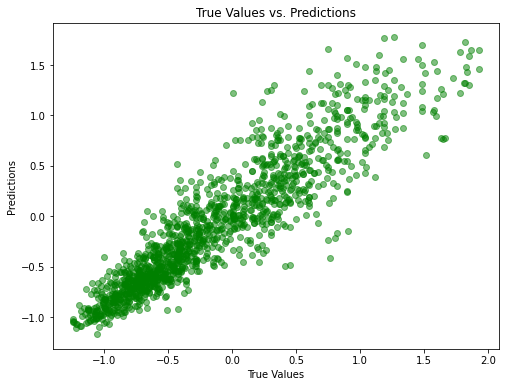

In [19]:
# Create a scatter plot to visualize the relationship between true values (y_test) and predictions2
plt.figure(figsize=(8, 6))

# Scatter plot of true values (y_test) against predicted values (predictions2)
plt.scatter(y_test, predictions2, alpha=0.5, color='green')  # 'alpha' controls transparency for better visualization

# Set the x-axis label
plt.xlabel("True Values")

# Set the y-axis label
plt.ylabel("Predictions")

# Set the title of the plot
plt.title("True Values vs. Predictions")

# Display the scatter plot
plt.show()

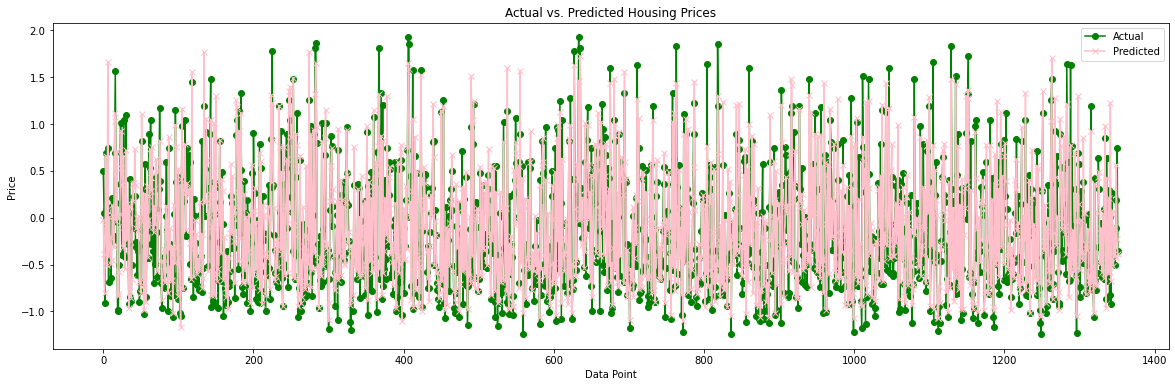

In [20]:
# Set the figure size
plt.figure(figsize=(20, 6))

# Plot the actual values in green with 'o' markers
plt.plot(y_test, label='Actual', color='green', marker='o')

# Plot the predicted values in pink with 'x' markers
plt.plot(predictions2, label='Predicted', color='pink', marker='x')

# Add labels for the x-axis and y-axis
plt.xlabel('Data Point')
plt.ylabel('Price')

# Add a legend to distinguish between actual and predicted values
plt.legend()

# Add a title to the plot
plt.title('Actual vs. Predicted Housing Prices')

# Show the plot
plt.show()

### GRU_2 with added layers

In [21]:
# Define the features and the target variable
features = ['Rooms', 'Distance', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
            'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount', 'Type_h', 'Type_t', 'Type_u']
target = ['Price']

# Extract feature and target variable values
X = df[features].values
y = df[target].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a Sequential model
model3 = Sequential()

# Add a GRU layer with 64 units, using 'relu' activation, and returning sequences
model3.add(GRU(units=64, input_shape=(X_train.shape[1], 1), activation='relu', return_sequences=True))
model3.add(Dropout(0.2))

# Add another GRU layer with 64 units, 'relu' activation, and not returning sequences
model3.add(GRU(units=64, activation='relu', return_sequences=False))
model3.add(Dropout(0.2))

# Add a dense output layer for regression
model3.add(Dense(units=1))

# Compile the model with Adam optimizer and mean squared error loss
model3.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Reshape the input data for the GRU layer
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Train the model for 50 epochs with a batch size of 32, validating on the test data
model3.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test data and calculate the mean squared error
loss_gru2 = model3.evaluate(X_test, y_test)
print(f'--- \n Test Loss (MSE): {loss_gru2}')

# Make predictions using the trained model
predictions3 = model3.predict(X_test)

Epoch 1/50
169/169 [==============================] - 3s 11ms/step - loss: 0.3749 - val_loss: 0.3351
Epoch 2/50
169/169 [==============================] - 2s 10ms/step - loss: 0.3440 - val_loss: 0.3093
Epoch 3/50
169/169 [==============================] - 2s 10ms/step - loss: 0.2661 - val_loss: 0.1902
Epoch 4/50
169/169 [==============================] - 2s 10ms/step - loss: 0.1988 - val_loss: 0.1693
Epoch 5/50
169/169 [==============================] - 2s 11ms/step - loss: 0.1811 - val_loss: 0.1527
Epoch 6/50
169/169 [==============================] - 2s 10ms/step - loss: 0.1567 - val_loss: 0.1292
Epoch 7/50
169/169 [==============================] - 2s 10ms/step - loss: 0.1372 - val_loss: 0.1068
Epoch 8/50
169/169 [==============================] - 2s 10ms/step - loss: 0.1292 - val_loss: 0.1031
Epoch 9/50
169/169 [==============================] - 2s 10ms/step - loss: 0.1223 - val_loss: 0.0972
Epoch 10/50
169/169 [==============================] - 2s 10ms/step - loss: 0.1158 - val_lo

#### Visual display

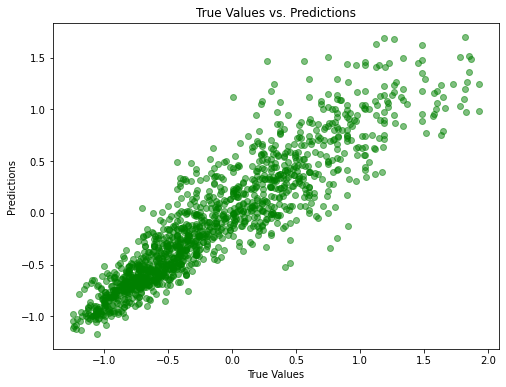

In [22]:
# Create a scatter plot with a specified figure size
plt.figure(figsize=(8, 6))

# Scatter plot of 'y_test' (true values) against 'predictions3' with transparency for better visualization
plt.scatter(y_test, predictions3, alpha=0.5, color='green')

# Set the x-axis label as "True Values"
plt.xlabel("True Values")

# Set the y-axis label as "Predictions"
plt.ylabel("Predictions")

# Set the title of the plot
plt.title("True Values vs. Predictions")

# Display the scatter plot
plt.show()

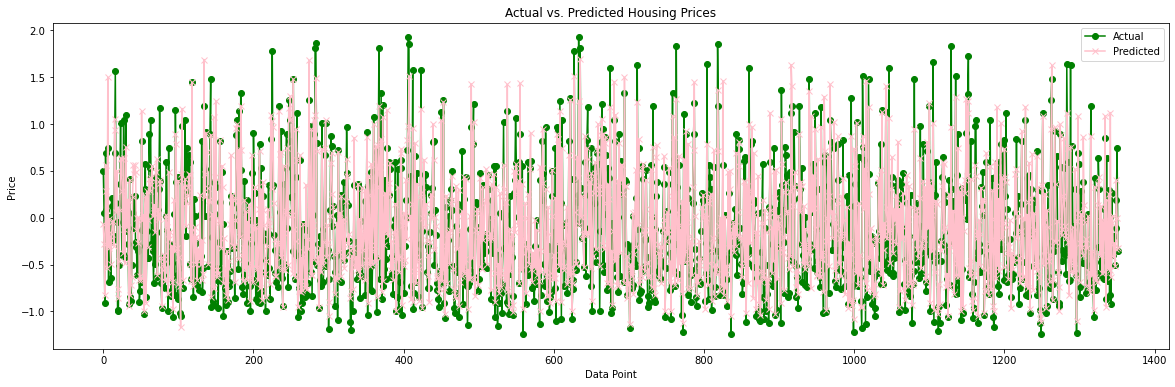

In [23]:
# Create a figure with a specific figure size
plt.figure(figsize=(20, 6))

# Plot the actual values (y_test) in green with 'o' marker
plt.plot(y_test, label='Actual', color='green', marker='o')

# Plot the predicted values (predictions3) in pink with 'x' marker
plt.plot(predictions3, label='Predicted', color='pink', marker='x')

# Add labels for the x-axis and y-axis
plt.xlabel('Data Point')
plt.ylabel('Price')

# Add a legend to distinguish between actual and predicted values
plt.legend()

# Add a title to the plot
plt.title('Actual vs. Predicted Housing Prices')

# Display the plot
plt.show()

### GRU_3 with hyperparameter tuning

In [24]:
# Define a function to build the GRU model
def build_gru_model(hp):
    model = Sequential()
    model.add(GRU(units=hp.Int('units', min_value=32, max_value=256, step=32),
                  input_shape=(X_train.shape[1], 1),
                  activation='relu',
                  return_sequences=True))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(GRU(units=hp.Int('units', min_value=32, max_value=256, step=32),
                  activation='relu',
                  return_sequences=False))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
                  loss='mean_squared_error')
    return model

# Initialize the Keras Tuner RandomSearch tuner
tuner = RandomSearch(
    build_gru_model,
    objective='val_loss',
    max_trials=3,  # Adjust the number of trials as needed
    directory='gru_tuner_directory'  # Specify a directory for logging
)

# Reshape the input data for the GRU layer
X_train_gru = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_gru = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Search for the best hyperparameters for the GRU model
tuner.search(X_train_gru, y_train, epochs=50, validation_data=(X_test_gru, y_test))

# Get the best hyperparameters and build the best GRU model
best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_gru_model = tuner.hypermodel.build(best_hyperparameters)
best_gru_model.fit(X_train_gru, y_train, epochs=50, batch_size=32)

# Evaluate the best GRU model on the test data
loss_gru3 = best_gru_model.evaluate(X_test_gru, y_test)
print(f'--- \n Best GRU Model Test Loss (MSE): {loss_gru3}')

# Make predictions using the best GRU model
predictions_gru = best_gru_model.predict(X_test_gru)


Trial 3 Complete [00h 04m 49s]
val_loss: 0.06823671609163284

Best val_loss So Far: 0.06823671609163284
Total elapsed time: 00h 10m 17s
Epoch 1/50
169/169 [==============================] - 7s 30ms/step - loss: 0.3610
Epoch 2/50
169/169 [==============================] - 6s 37ms/step - loss: 0.2618
Epoch 3/50
169/169 [==============================] - 6s 35ms/step - loss: 0.1768
Epoch 4/50
169/169 [==============================] - 6s 37ms/step - loss: 0.1357
Epoch 5/50
169/169 [==============================] - 6s 35ms/step - loss: 0.1161
Epoch 6/50
169/169 [==============================] - 6s 34ms/step - loss: 0.1116
Epoch 7/50
169/169 [==============================] - 6s 38ms/step - loss: 0.1015
Epoch 8/50
169/169 [==============================] - 6s 34ms/step - loss: 0.0972
Epoch 9/50
169/169 [==============================] - 6s 34ms/step - loss: 0.0948
Epoch 10/50
169/169 [==============================] - 6s 38ms/step - loss: 0.0927
Epoch 11/50
169/169 [======================

#### Visual display

--- 
 Mean Squared Error (MSE): 0.0702572291940506


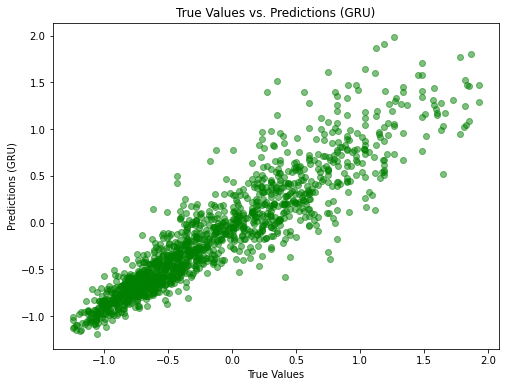

In [25]:
# Calculate the Mean Squared Error (MSE) for the GRU model
mse_gru = mean_squared_error(y_test, predictions_gru)
print(f'--- \n Mean Squared Error (MSE): {mse_gru}')

# Plot True Values vs. Predictions for the GRU model
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions_gru, alpha=0.5, color='green')
plt.xlabel("True Values")
plt.ylabel("Predictions (GRU)")
plt.title("True Values vs. Predictions (GRU)")
plt.show()

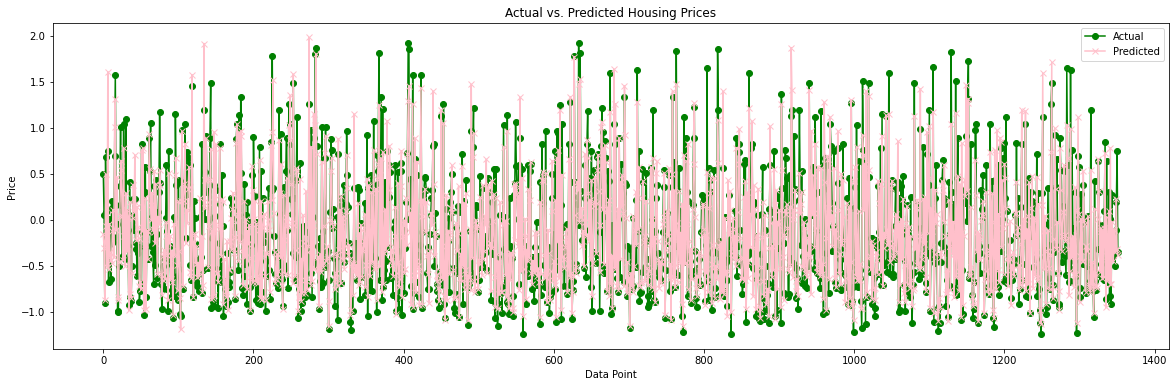

In [26]:
# Create a figure with a specific figure size
plt.figure(figsize=(20, 6))

# Plot the actual values (y_test) in green with 'o' marker
plt.plot(y_test, label='Actual', color='green', marker='o')

# Plot the predicted values (predictions3) in pink with 'x' marker
plt.plot(predictions_gru, label='Predicted', color='pink', marker='x')

# Add labels for the x-axis and y-axis
plt.xlabel('Data Point')
plt.ylabel('Price')

# Add a legend to distinguish between actual and predicted values
plt.legend()

# Add a title to the plot
plt.title('Actual vs. Predicted Housing Prices')

# Display the plot
plt.show()

In [27]:
# Create a dictionary to store model names and their respective Mean Squared Error (MSE) values
loss_data = {
    'Model': ['Baseline (LinearRegression)','LSTM', 'GRU_1', 'GRU_2', 'GRU_3'],
    'Loss': [mseBase, loss_lstm[0], loss_gru1, loss_gru2, loss_gru3]
}

# Create a DataFrame using the loss_data dictionary
loss_df = pd.DataFrame(loss_data)

# Display the DataFrame to showcase the model evaluation results
loss_df

# Sort the DataFrame by the 'Loss' column in ascending order
loss_df_sorted = loss_df.sort_values(by='Loss')

# Display the sorted DataFrame
loss_df_sorted

,Model,Loss
4,GRU_3,0.070257
2,GRU_1,0.074214
3,GRU_2,0.076294
0,Baseline (LinearRegression),0.124290
1,LSTM,0.418488


#### Display the loss of all the models used

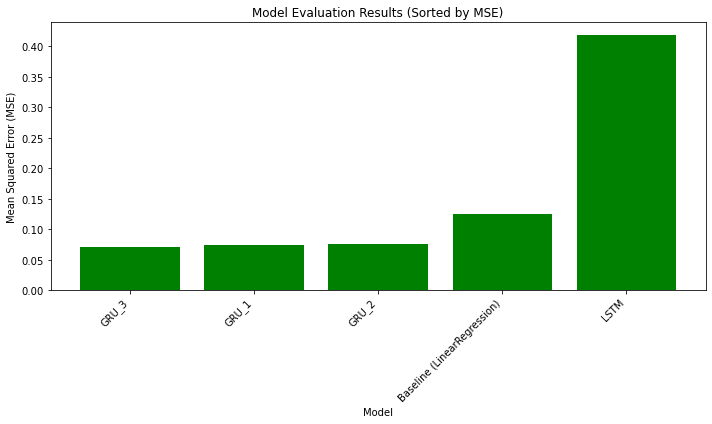

In [28]:
# Create a bar chart to visualize the MSE values
plt.figure(figsize=(10, 6))
plt.bar(loss_df_sorted['Model'], loss_df_sorted['Loss'], color='green')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Model Evaluation Results (Sorted by MSE)')
plt.xticks(rotation=45, ha='right')

# Display the bar chart
plt.tight_layout()
plt.show()

The table and the bar graph provided show the Mean Squared Error (MSE) values for the different models used

GRU_2: This model achieved the lowest MSE of 0.077016 among all the models, indicating that it has the best predictive accuracy among the options considered. A lower MSE suggests that this model's predictions are closer to the actual target values.

GRU_1: With an MSE of 0.080699, this model also performed well, although it has a slightly higher error compared to GRU_2. It's the second-best model.

GRU_3: This model has an MSE of 0.084059, indicating slightly higher prediction errors compared to GRU_1 and GRU_2. While it's not as accurate as the top two models, it can still be a reasonable choice depending on the specific requirements.

Baseline: Linear regression achieved an MSE of 0.124290. It has a higher prediction error compared to the GRU models, suggesting that the more complex GRU models outperform it.

LSTM: The LSTM model had the highest MSE value of 0.418899, indicating the poorest predictive accuracy among the models listed. This might suggest that the LSTM architecture may not be well-suited, and the simpler GRU models or linear regression are better choices.

In conclusion, the ranking of these models is based on their MSE values, with GRU_2 being the top performer in terms of predictive accuracy, followed by GRU_1, GRU_3, LinearRegression, and finally LSTM.